In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class annealing():

    """LOADING"""

    """
    This is the python2 version of the stochastic inversion algorithm Simulated Annealing
    shown in the dissertation with the link below

    https://www.pge.utexas.edu/images/pdfs/theses18/shiriyev_dis_18.pdf

    page 85-88. In the algorithm the general approach of Simulated Annealing is
    coupled with the ideas from Genetic Algorithm.

    User needs to define number of generations (nog),
    number of models in each generation (nom),
    number of parameters for each model (nop),
    minimum and maximum values for each parameter (m_min & m_max), and
    temperature profile (T, control parameter).
    """

    def __init__(self,m_min,m_max,nog,nom,nop):
        
        self.m_min = m_min
        self.m_max = m_max
        
        self.nog = nog
        self.nom = nom
        self.nop = nop

    def temperature(self,tempType="straight"):
        
        self.tempType = tempType

        Tinit = 1.
        Tfnal = 1.e-2
        
        M = self.nog
        e = np.array(range(1,M+1))
        
        if self.tempType == "straight":
            self.tmp = Tinit+(Tfnal-Tinit)/(M-1.)*(e-1.)
        elif self.tempType ==  "geometric":
            self.tmp = Tinit*(Tfnal/Tinit)**((e-1.)/(M-1.))
        elif self.tempType == "reciprocal":
            self.tmp = Tinit*Tfnal*(M-1)/(Tfnal*M-Tinit+(Tinit-Tfnal)*e)
        elif self.tempType == "logarithmic":
            self.tmp = Tinit*Tfnal*np.log((M+1)/2)/(Tfnal*np.log(M+1)- \
            Tinit*np.log(2)+(Tinit-Tfnal)*np.log(e+1))
        
    def iterating(self,objective):
        
        models = np.zeros([self.nom,self.nop,self.nog])
        energy = np.zeros([self.nog,self.nom]) 
        
        #np.random.seed(1)
        #R1 = np.random.rand(self.nom*self.nop).reshape(self.nop,self.nom).T
        R1 = np.random.rand(self.nom,self.nop)
        
        m1 = self.m_min+R1*(self.m_max-self.m_min)
        E1 = objective(m1)

        print("iteration number 1 is complete...")

        models[:,:,0] = m1
        energy[0,:] = E1
        
        m1,E1 = self.selection(m1,E1)
        
        for i in range(1,self.nog):
           
           m2 = self.offspring(m1,self.tmp[i])
           E2 = objective(m2)
           
           models[:,:,i] = m2
           energy[i,:] = E2
            
           dE = E2-E1
           
           #np.random.seed(2)
           R2 = np.random.rand(self.nom)
           
           pA = np.logical_or(dE<=0,self.tmp[i]>R2)
            
           m1[pA,:] = m2[pA,:]
           E1[pA] = E2[pA]
        
           m1,E1 = self.selection(m1,E1)

           print("iteration number "+str(i+1)+" is complete...")

        self.models = np.transpose(models,(2,1,0))
        self.energy = energy
        
    def selection(self,m,E):
        
        for n in range(int(self.nom/2)+1):
        
           id_min = np.argmin(E)
           id_max = np.argmax(E)
        
           m[id_max,:] = m[id_min,:]
           E[id_max] = E[id_min]
           
        return m,E
        
    def offspring(self,m_old,tmp_i):
        
        deltam = np.tile(self.m_max-self.m_min,[self.nom,1])
        
        m_new = m_old.copy()
        
        out = np.ones((self.nom,self.nop),dtype=bool)
        
        for ntry in range(100):

            #np.random.seed(ntry+1)
            #R3 = np.random.rand(self.nom*self.nop).reshape(self.nop,self.nom).T
            R3 = np.random.rand(self.nom,self.nop)
            pole = np.sign(R3-0.5)
            
            #np.random.seed(ntry+1)
            #R4 = np.random.rand(self.nom*self.nop).reshape(self.nop,self.nom).T
            R4 = np.random.rand(self.nom,self.nop)
            jump = R4*tmp_i
            
            m_new[out] = m_old[out]+pole[out]*jump[out]*deltam[out]
            
            out = np.logical_or(m_new<self.m_min,m_new>self.m_max)
            
            if np.all(~out):
                break
           
        if ntry == 99:

            print("ERROR: could not find search point")
           
        return m_new

    def plotError(self):

        self.min_energy = self.energy.min(1)
        self.idx_of_min = self.energy.argmin(axis=1)

        self.min_param = np.zeros([self.nog,self.nop])

        for i in range(self.nog):
            self.min_param[i,:] = self.models[i,:,self.idx_of_min[i]]

        plt.figure(num='Error Evolution',figsize=[6.72,5.04])

        l1 = plt.semilogy(range(1,self.nog+1),self.min_energy, \
                          'o',ms=4,mec='r',mfc='r')

        for i in range(0,self.nom,5):
            l2 = plt.semilogy(range(1,self.nog+1),self.energy[:,i], \
                          'o',ms=4,mec='k',mfc='none')

        plt.legend(['best model','other models'],loc='lower center', \
                   numpoints=1,ncol=2,prop={'size':11})

        plt.xlabel('iteration number')
        plt.ylabel('objective function')

        plt.xlim([0,self.nog])

        plt.show()

def testfunc(m):

    if type(m) is not np.ndarray:
        m = np.array([m])

    lhs = np.sign(np.sinc(m))
    rhs = np.power(np.abs(np.sinc(m)),1./4)
    
    capi = np.prod(lhs*rhs,1)
    cost = np.power(1.-capi,2.)
    
    return cost

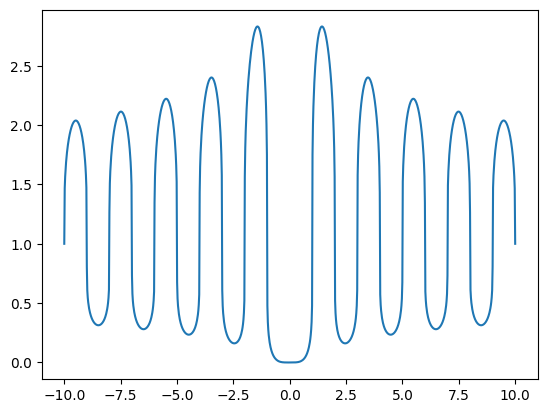

In [3]:
m = np.linspace(-10,10,1000)

E = testfunc(np.array([m]).T)

plt.plot(m,E)
plt.show()

# nog = 100   #50
# nom = 25    #3
# nop = 5     #2

# m_min = np.ones([1,nop])*-10    #0,0
# m_max = np.ones([1,nop])*10     #10,10

# model = annealing(m_min,m_max,nog,nom,nop)

# #T = model.temperature('straight') #straight
# T = model.temperature('geometric')
# #T = model.temperature('reciprocal')
# #T = model.temperature('logarithmic')

# model.iterating(testfunc)

# plt.figure(num=1)

# X = np.array(range(1,nog+1))

# plt.plot(X,T1)
# plt.plot(X,T2)
# plt.plot(X,T3)
# plt.plot(X,T4)

# plt.xlim([0.,nog])
# plt.ylim([0.,1.])

# plt.show()